In [128]:
import rosbag2_py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from geopy.distance import geodesic
import folium
import string
import seaborn as sns
from scipy import stats
import math

In [129]:
data_path = "/home/mostafa/labs/lab3_ws/topic.csv"

In [130]:
imu_df = pd.read_csv(data_path)

In [131]:
imu_df.head()

,1728510494,189278929,IMU1_Frame,0,0.1,Unnamed: 5,-0.006477519121025054,0.0329694398146986,-0.17570757697369074,0.9838688455167062,...,0.0744,0.4155,0.612,0.224,-9.726,-0.006182,0.004392,-0.00332,-0.006477519121025054,0.0...
0,1728510494,214290462,IMU1_Frame,0,0,NaN,-0.006454,0.032964,-0.175640,0.983881,...,0.0541,0.4133,0.611,0.224,-9.760,-0.008467,0.005062,0.00136,-0.006454,0.0329...
1,1728510494,239241163,IMU1_Frame,0,0,NaN,-0.006448,0.032954,-0.175623,0.983885,...,0.0508,0.4195,0.607,0.244,-9.774,-0.008857,0.004250,0.00119,-0.006448,0.032...
2,1728510494,264211030,IMU1_Frame,0,0,NaN,-0.006433,0.032942,-0.175607,0.983888,...,0.0575,0.4023,0.598,0.218,-9.791,0.001174,-0.001004,0.00250,-0.006433,0.032...
3,1728510494,289292730,IMU1_Frame,0,0,NaN,-0.006442,0.032944,-0.175572,0.983894,...,0.0677,0.4154,0.599,0.217,-9.758,0.007537,-0.004053,0.00121,-0.006442,0.0329...
4,1728510494,314181014,IMU1_Frame,0,0,NaN,-0.006469,0.032948,-0.175554,0.983897,...,0.0530,0.4035,0.616,0.258,-9.756,0.005463,-0.002496,0.00275,-0.006469,0.03294...


# Perform Some Data Cleaning

In [132]:
df = imu_df

In [133]:
#drop the columns that have all zeros
df = df.drop(columns=df.columns[(df == 0).all(axis=0)])

In [134]:
#drop the empty unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [135]:
#drop the raw data
df = df.drop(df.columns[16:], axis=1)

In [136]:
df.columns = ['secs', 'nsecs', 'frame_id', 'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w', 'angular_velocity_x', 'angular_velocity_y', 'angular_velocity_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'mag_x', 'mag_y', 'mag_z']

In [137]:
df['time'] = (df['secs'] - df['secs'].min()) + (df['nsecs'] * 1e-9)

In [148]:
df['mag_x'] = df['mag_x']*10000
df['mag_y'] = df['mag_y']*10000
df['mag_z'] = df['mag_z']*10000

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28264 entries, 0 to 28263
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   secs                   28264 non-null  int64  
 1   nsecs                  28264 non-null  int64  
 2   frame_id               28264 non-null  object 
 3   orientation_x          28264 non-null  float64
 4   orientation_y          28264 non-null  float64
 5   orientation_z          28264 non-null  float64
 6   orientation_w          28264 non-null  float64
 7   angular_velocity_x     28264 non-null  float64
 8   angular_velocity_y     28264 non-null  float64
 9   angular_velocity_z     28264 non-null  float64
 10  linear_acceleration_x  28264 non-null  float64
 11  linear_acceleration_y  28264 non-null  float64
 12  linear_acceleration_z  28264 non-null  float64
 13  mag_x                  28264 non-null  float64
 14  mag_y                  28264 non-null  float64
 15  ma

In [139]:
def euler_from_quaternion(x, y, z, w):
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians

# Normalize and Analyze

In [140]:
#calculate the euler angles
df['roll'], df['pitch'], df['yaw'] = zip(*df.apply(lambda x: euler_from_quaternion(x['orientation_x'], x['orientation_y'], x['orientation_z'], x['orientation_w']), axis=1))


In [150]:
#Normalize data to zero reference it and be able to see the changeds in the data
df['angular_velocity_x'] = df['angular_velocity_x'] - df['angular_velocity_x'].min()
df['angular_velocity_y'] = df['angular_velocity_y'] - df['angular_velocity_y'].min()
df['angular_velocity_z'] = df['angular_velocity_z'] - df['angular_velocity_z'].min()

df['linear_acceleration_x'] = df['linear_acceleration_x'] - df['linear_acceleration_x'].min()
df['linear_acceleration_y'] = df['linear_acceleration_y'] - df['linear_acceleration_y'].min()
df['linear_acceleration_z'] = df['linear_acceleration_z'] - df['linear_acceleration_z'].min()

df['mag_x'] = df['mag_x'] - df['mag_x'].min()
df['mag_y'] = df['mag_y'] - df['mag_y'].min()
df['mag_z'] = df['mag_z'] - df['mag_z'].min()

In [109]:
df.to_csv('imu_data.csv', index=False)

In [151]:
#calculate mean and std
#roll, pitch and yaw
mean = []
std = []
for column in df.columns[7:-1]:
    mean.append(df[column].mean())
    std.append(df[column].std())
    print("Mean of %s = %.17f" % (column, mean[-1]))
    print("Std of %s = %.17f" % (column, std[-1]))
    print("=====================================")



Mean of angular_velocity_x = 0.03712594066657231
Std of angular_velocity_x = 0.00656154896123406
Mean of angular_velocity_y = 0.01757471069204642
Std of angular_velocity_y = 0.00319309780195430
Mean of angular_velocity_z = 0.00553119799037645
Std of angular_velocity_z = 0.00195239089408507
Mean of linear_acceleration_x = 0.05365609963204069
Std of linear_acceleration_x = 0.01313650578832235
Mean of linear_acceleration_y = 0.07614690065100481
Std of linear_acceleration_y = 0.01682555975531726
Mean of linear_acceleration_z = 0.10846957260118890
Std of linear_acceleration_z = 0.02794281354991423
Mean of mag_x = 59.74922162468151754
Std of mag_x = 15.87872929124370813
Mean of mag_y = 119.25764223039909950
Std of mag_y = 53.21204669794271069
Mean of mag_z = 221.22141239739599428
Std of mag_z = 65.66472962942827962
Mean of time = 353.50663157095902989
Std of time = 203.98804648364986747
Mean of roll = -0.02414952323401395
Std of roll = 0.00016769619423315
Mean of pitch = 0.06247254705900454


In [168]:
def plot_time_graphs(columns, title, unit):
    fig, ax = plt.subplots(3, 1, figsize=(15, 10))
    for i, column in enumerate(columns):
        ax[i].plot(df['time'].to_numpy(), df[column].to_numpy(), label=column)
        ax[i].set_xlabel('Time (s)')
        ax[i].set_ylabel(column+' ('+unit+')')
        ax[i].set_title(title)
    plt.tight_layout()
    plt.show()

def plot_histogrames(columns, title, unit):
    fig, ax = plt.subplots(3, 1, figsize=(15, 10))
    for i, column in enumerate(columns):
        ax[i].hist(df[column].to_numpy(), bins=100, label=column)
        ax[i].set_xlabel(column+' ('+unit+')')
        ax[i].set_ylabel('Frequency')
        ax[i].set_title(title)
    plt.tight_layout()
    plt.show()
    

def check_distribution_QQ(columns):
    fig, ax = plt.subplots(3, 1, figsize=(15, 10))
    for i, column in enumerate(columns):
        stats.probplot(df[column].to_numpy(), dist="norm", plot=ax[i])
        ax[i].set_title(f"QQ Plot - {column}")
    plt.tight_layout()
    plt.show()



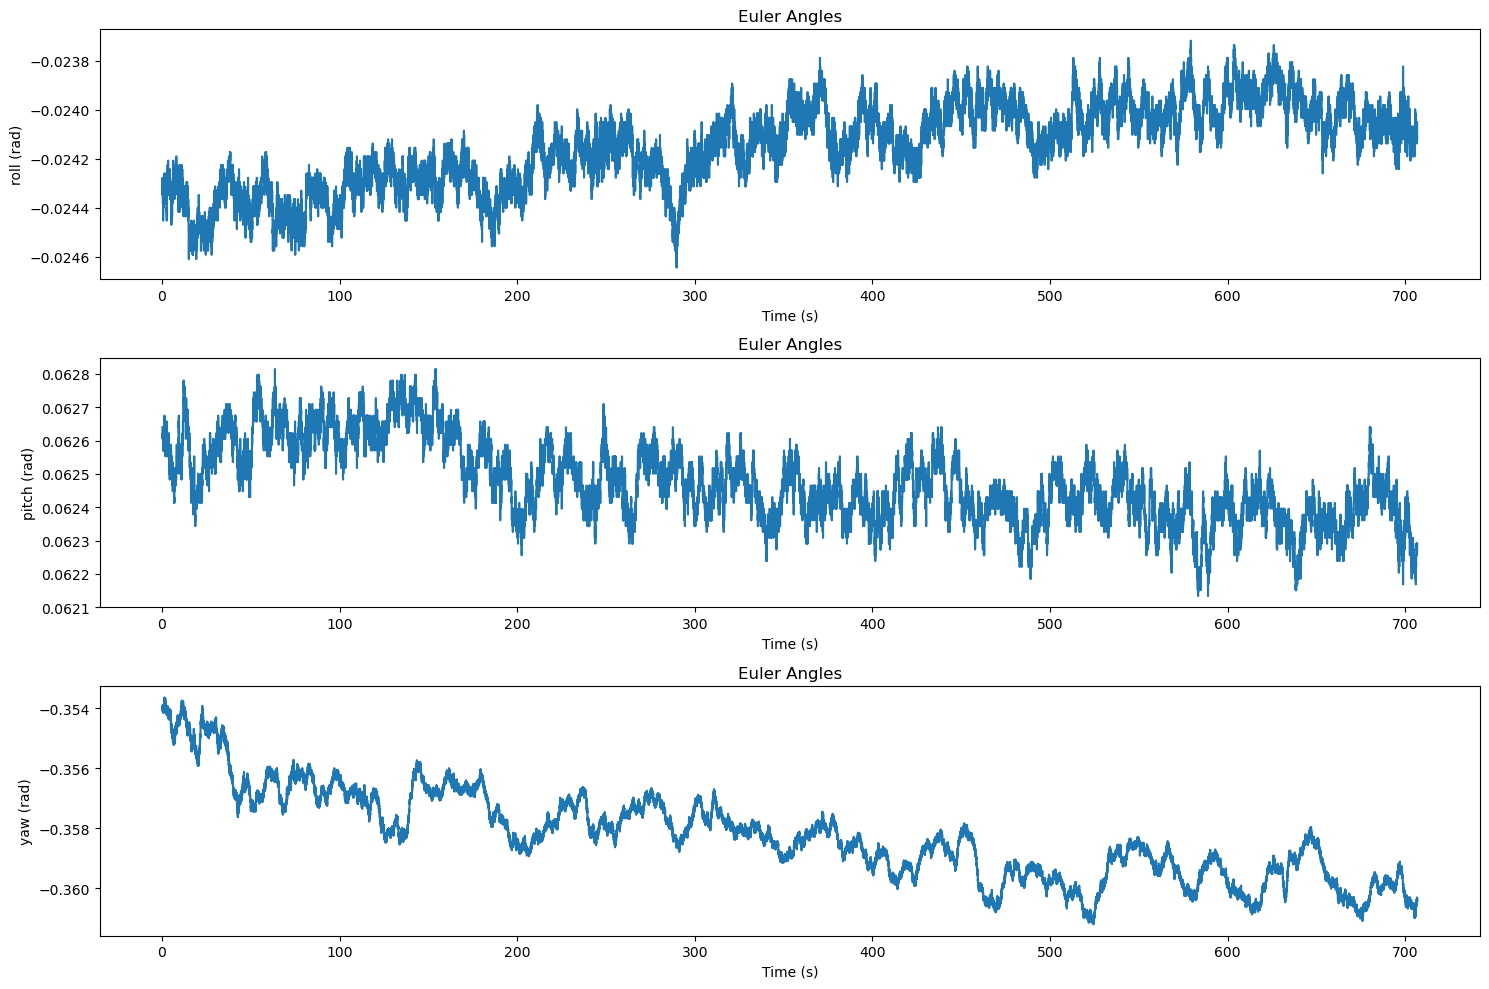

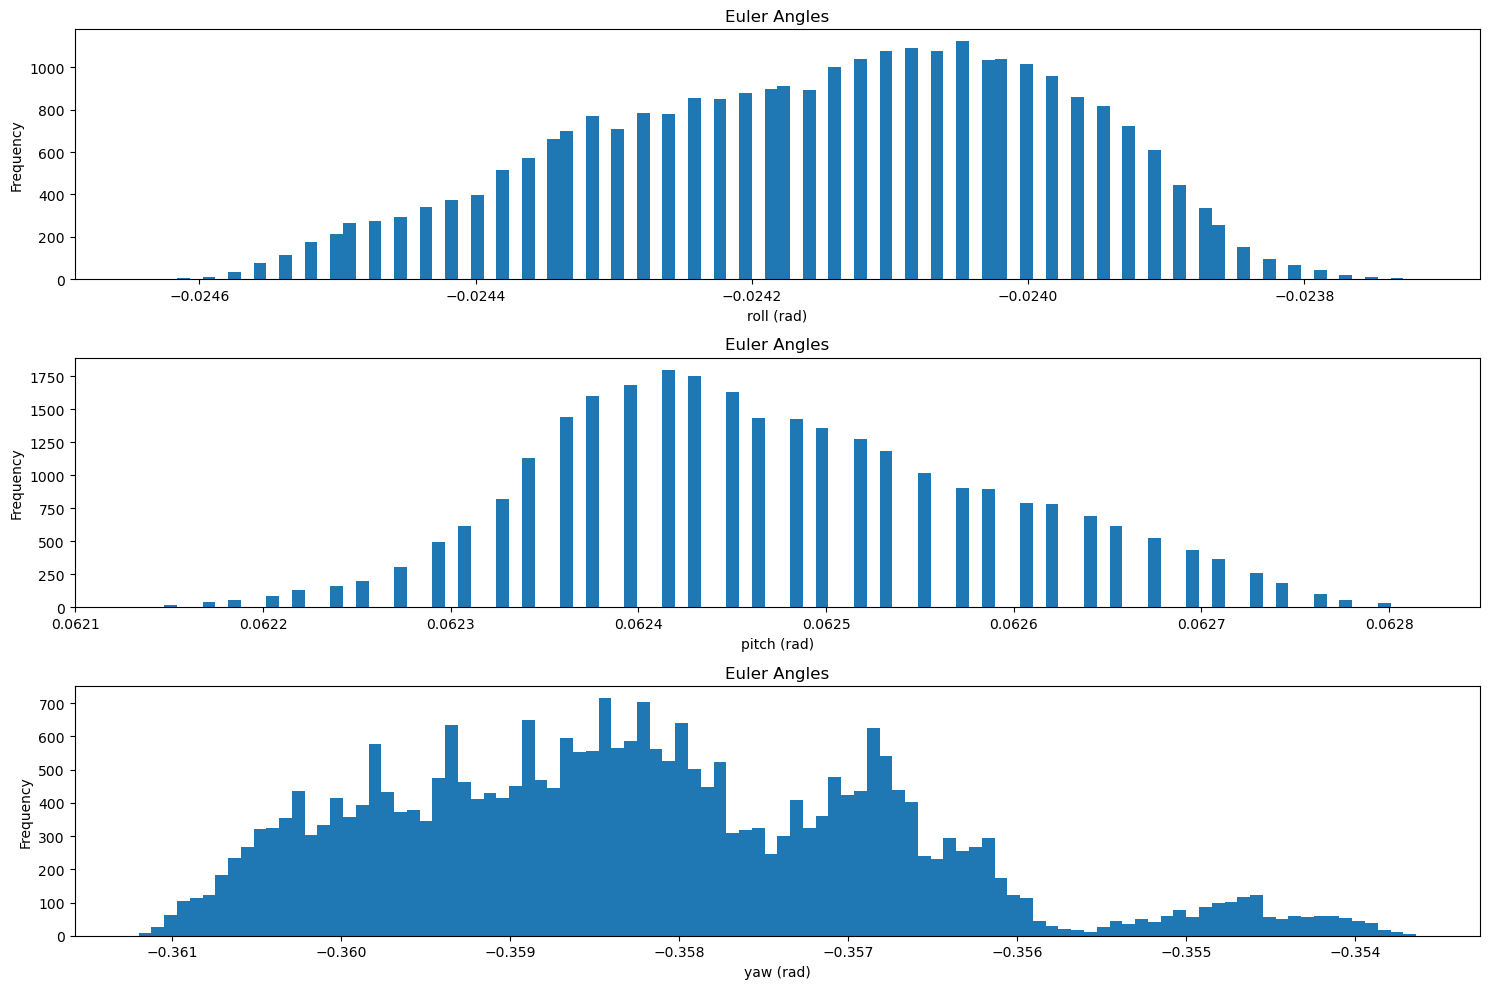

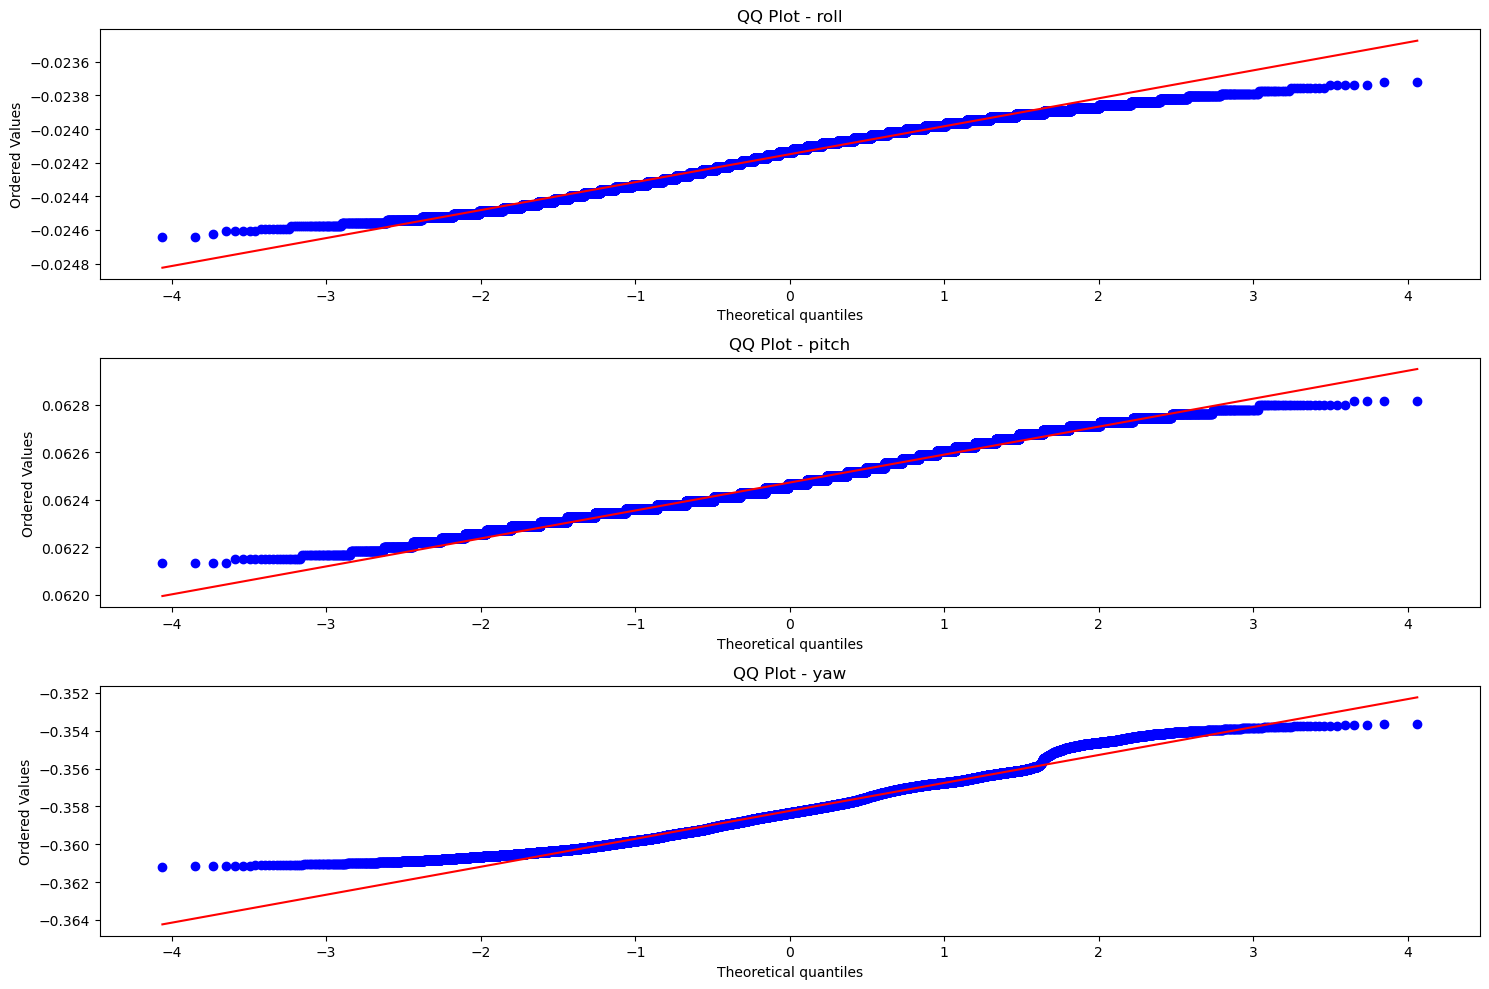

In [170]:
plot_time_graphs(['roll', 'pitch', 'yaw'], 'Euler Angles', 'rad')
plot_histogrames(['roll', 'pitch', 'yaw'], 'Euler Angles', 'rad')
check_distribution_QQ(['roll', 'pitch', 'yaw'])

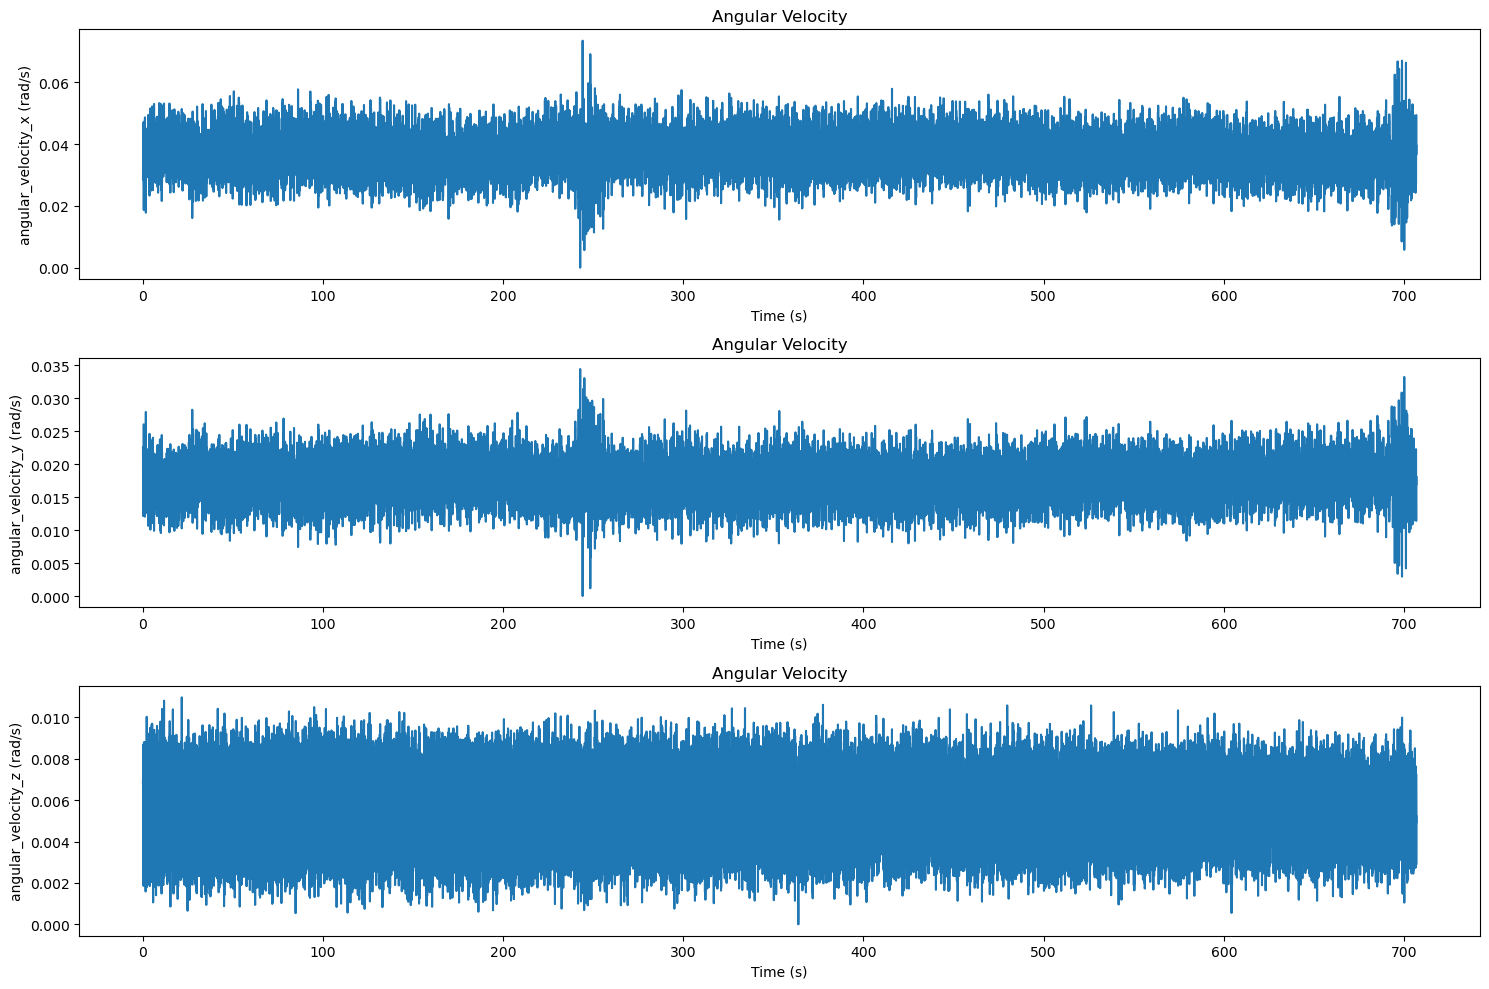

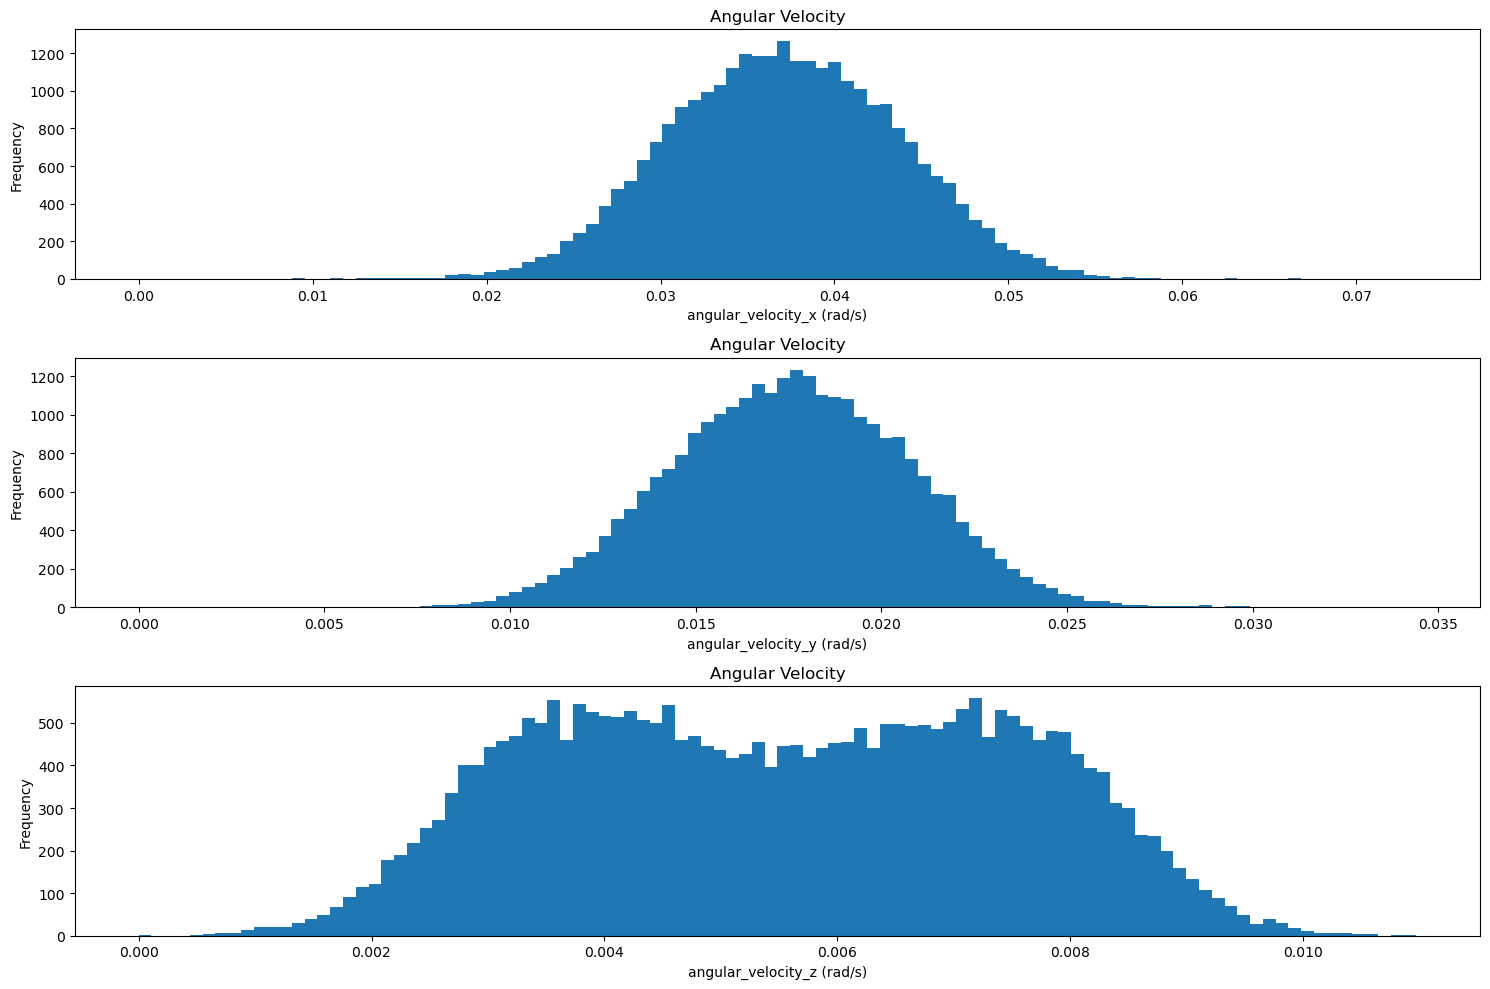

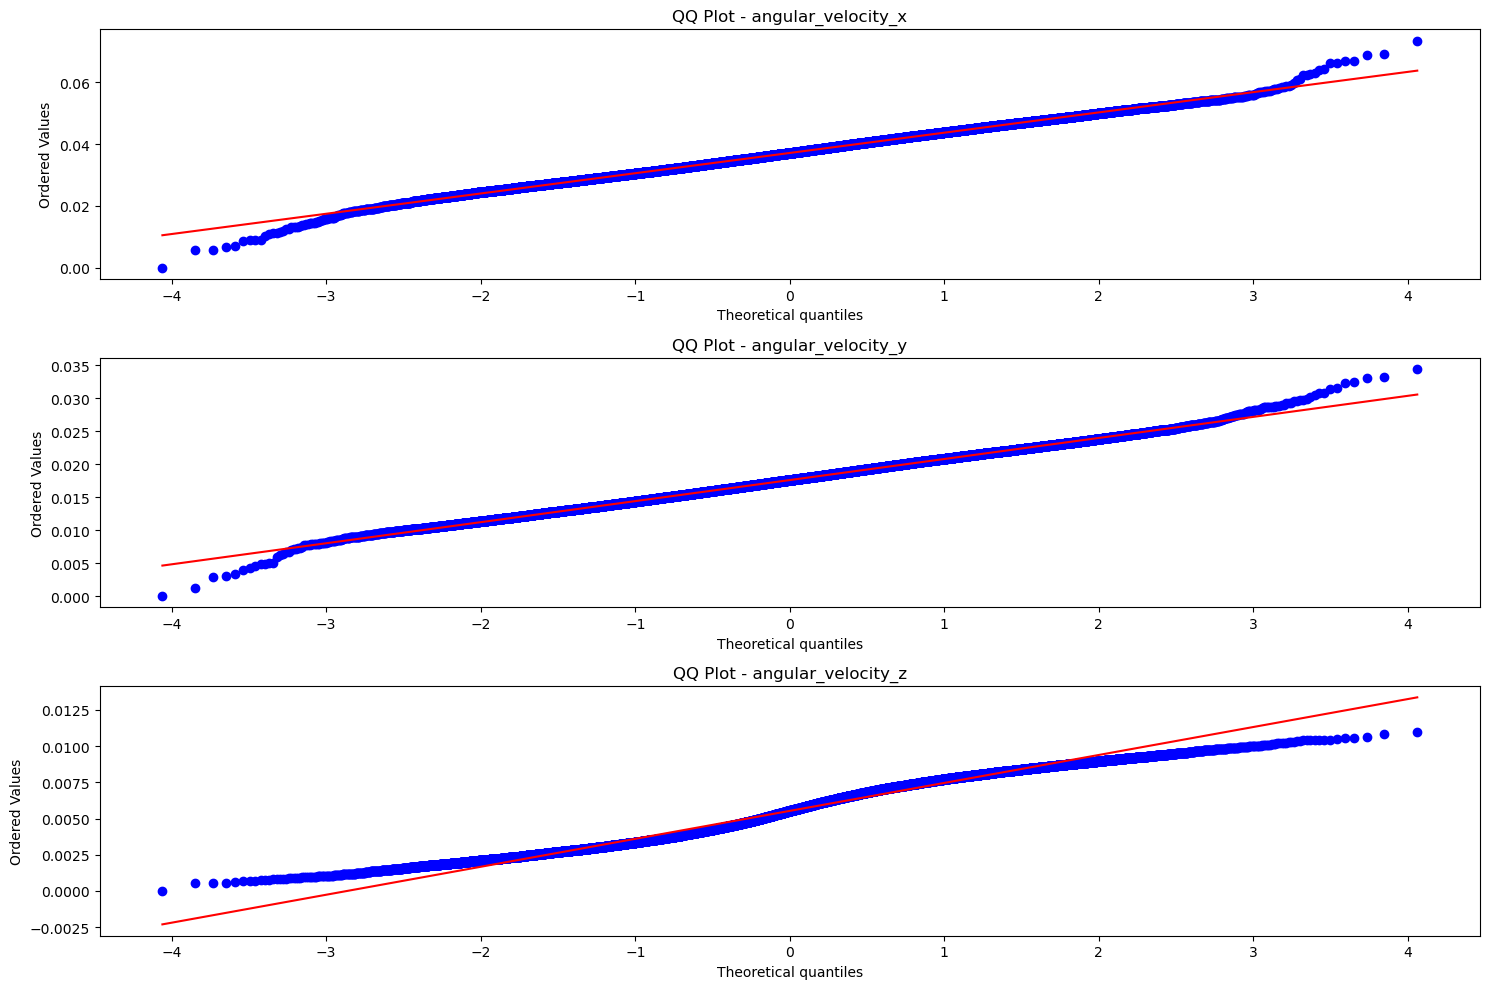

In [171]:
plot_time_graphs(['angular_velocity_x', 'angular_velocity_y', 'angular_velocity_z'], 'Angular Velocity', 'rad/s')
plot_histogrames(['angular_velocity_x', 'angular_velocity_y', 'angular_velocity_z'], 'Angular Velocity', 'rad/s')
check_distribution_QQ(['angular_velocity_x', 'angular_velocity_y', 'angular_velocity_z'])

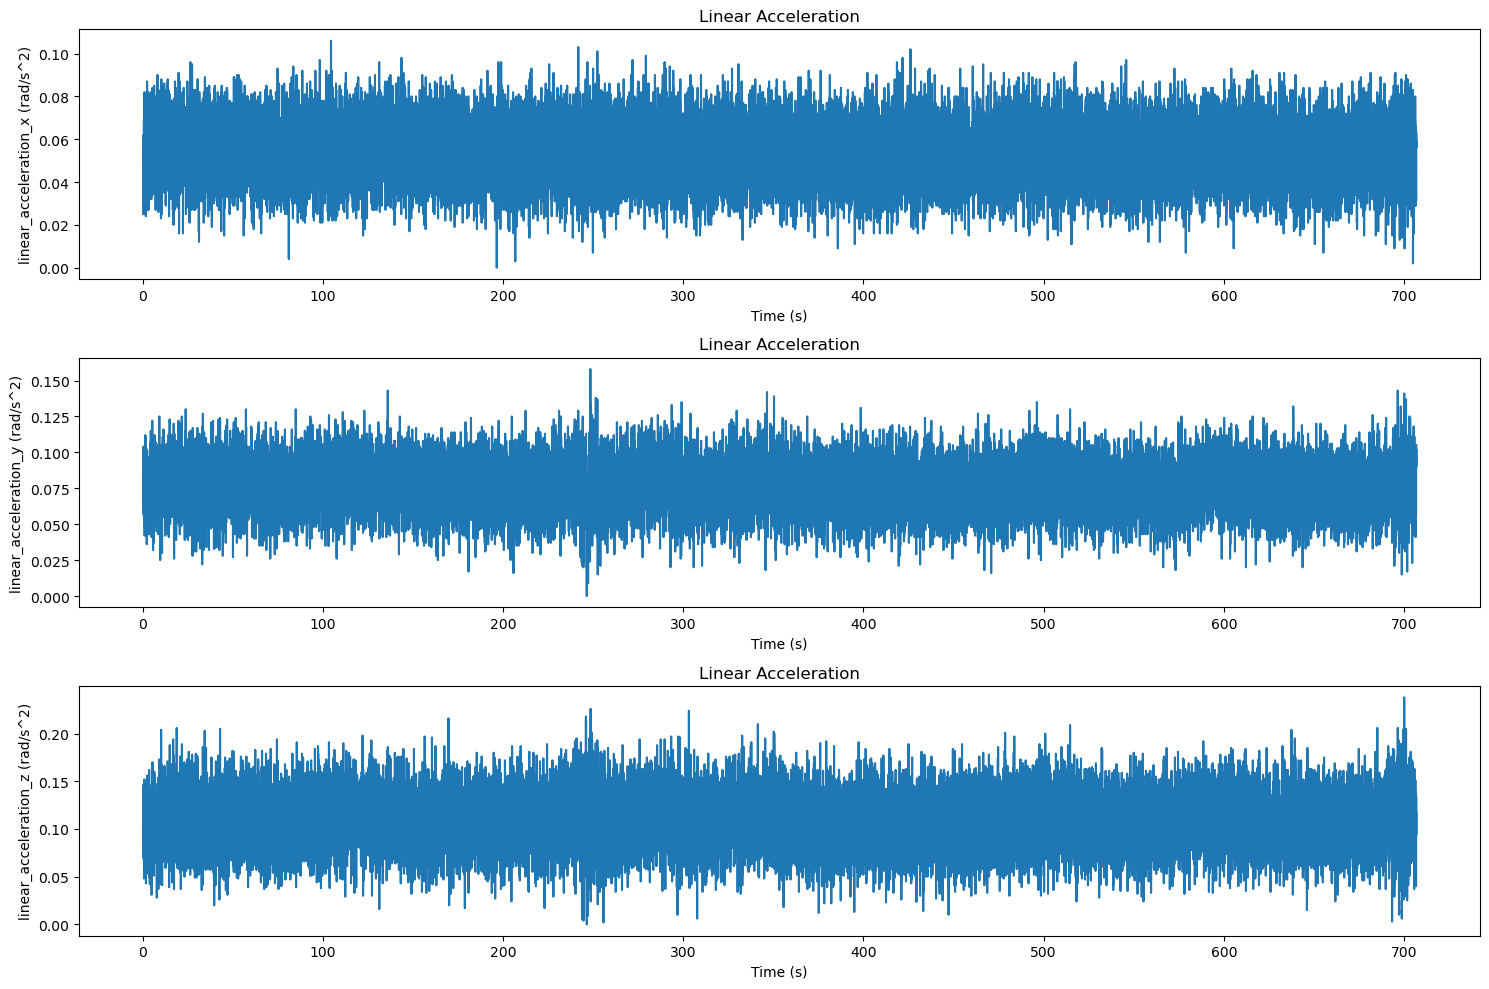

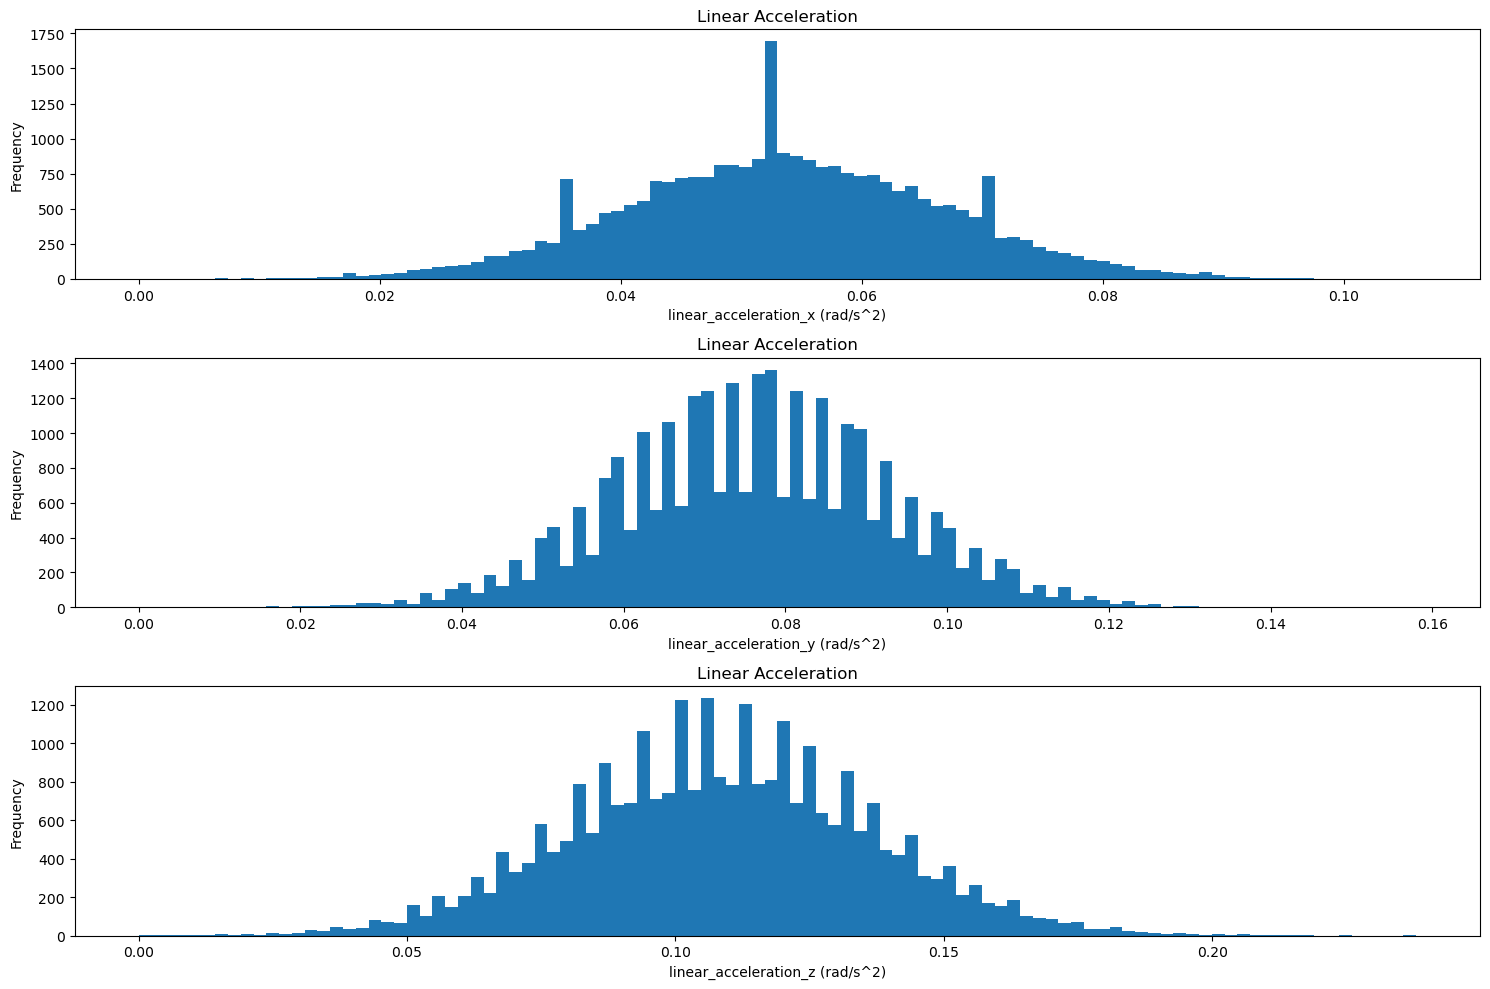

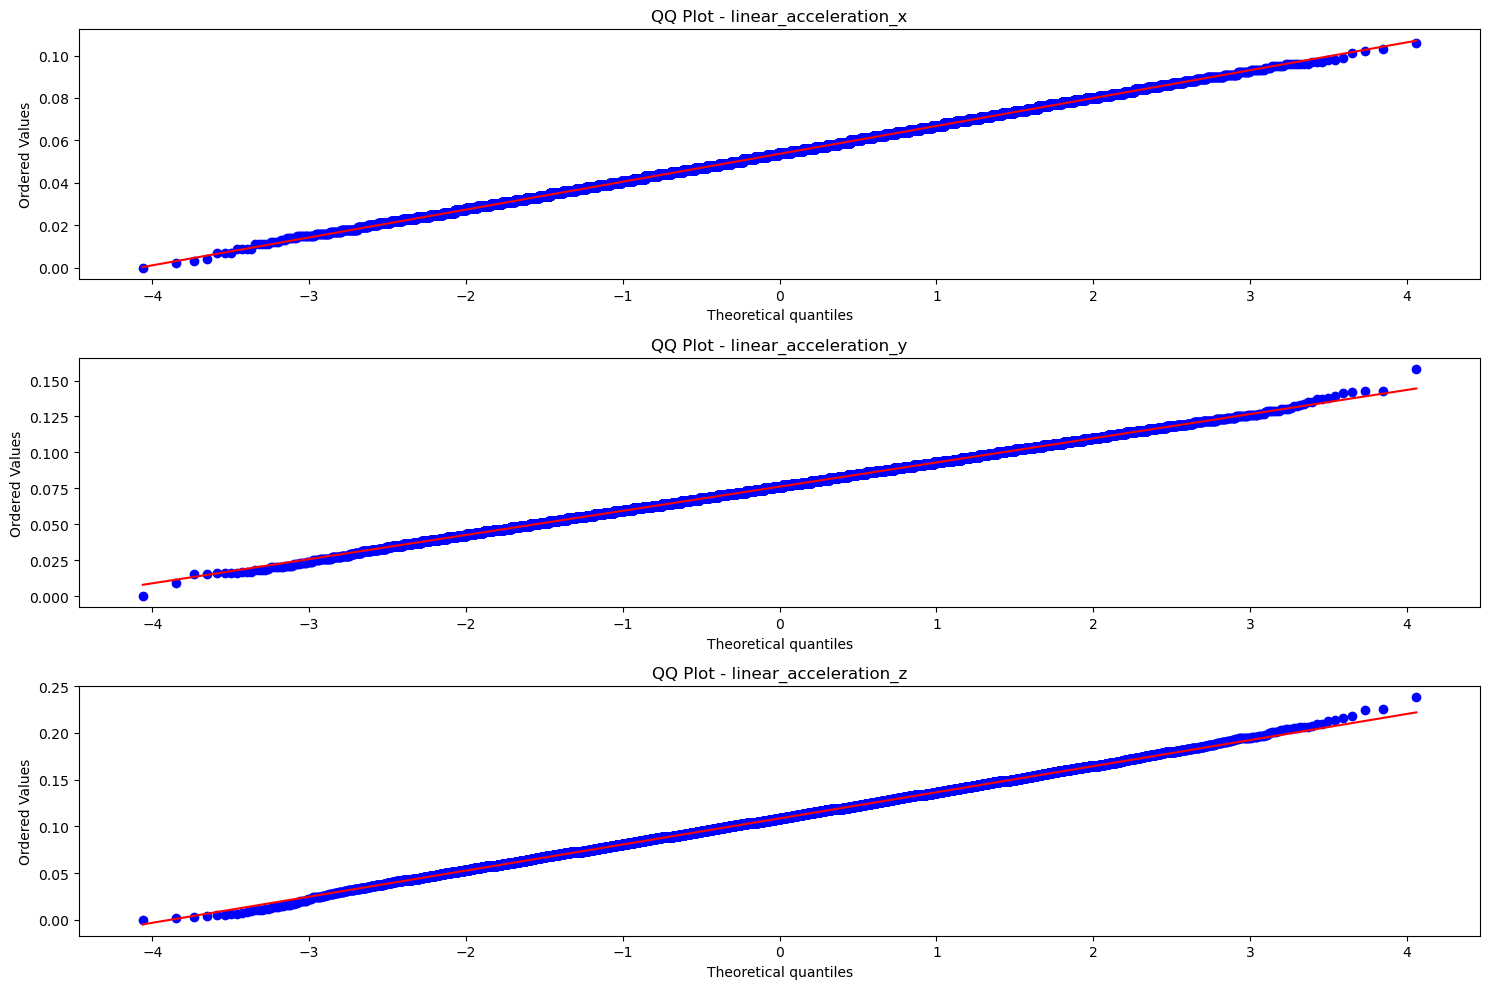

In [172]:
plot_time_graphs(['linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z'], 'Linear Acceleration', 'rad/s^2')
plot_histogrames(['linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z'], 'Linear Acceleration', 'rad/s^2')
check_distribution_QQ(['linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z'])

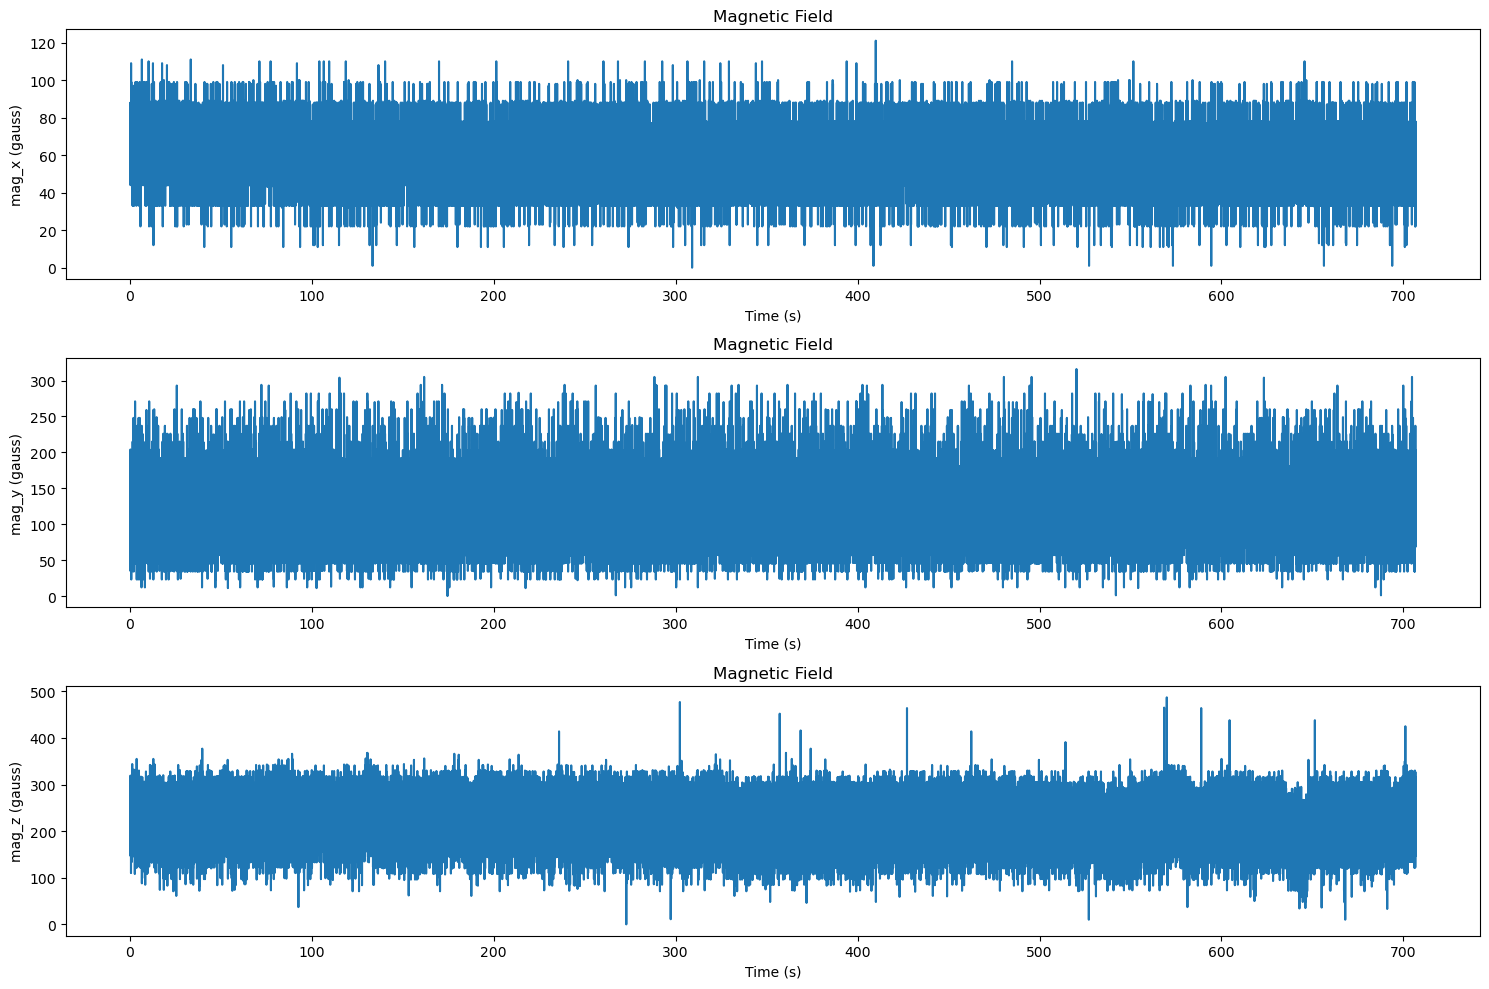

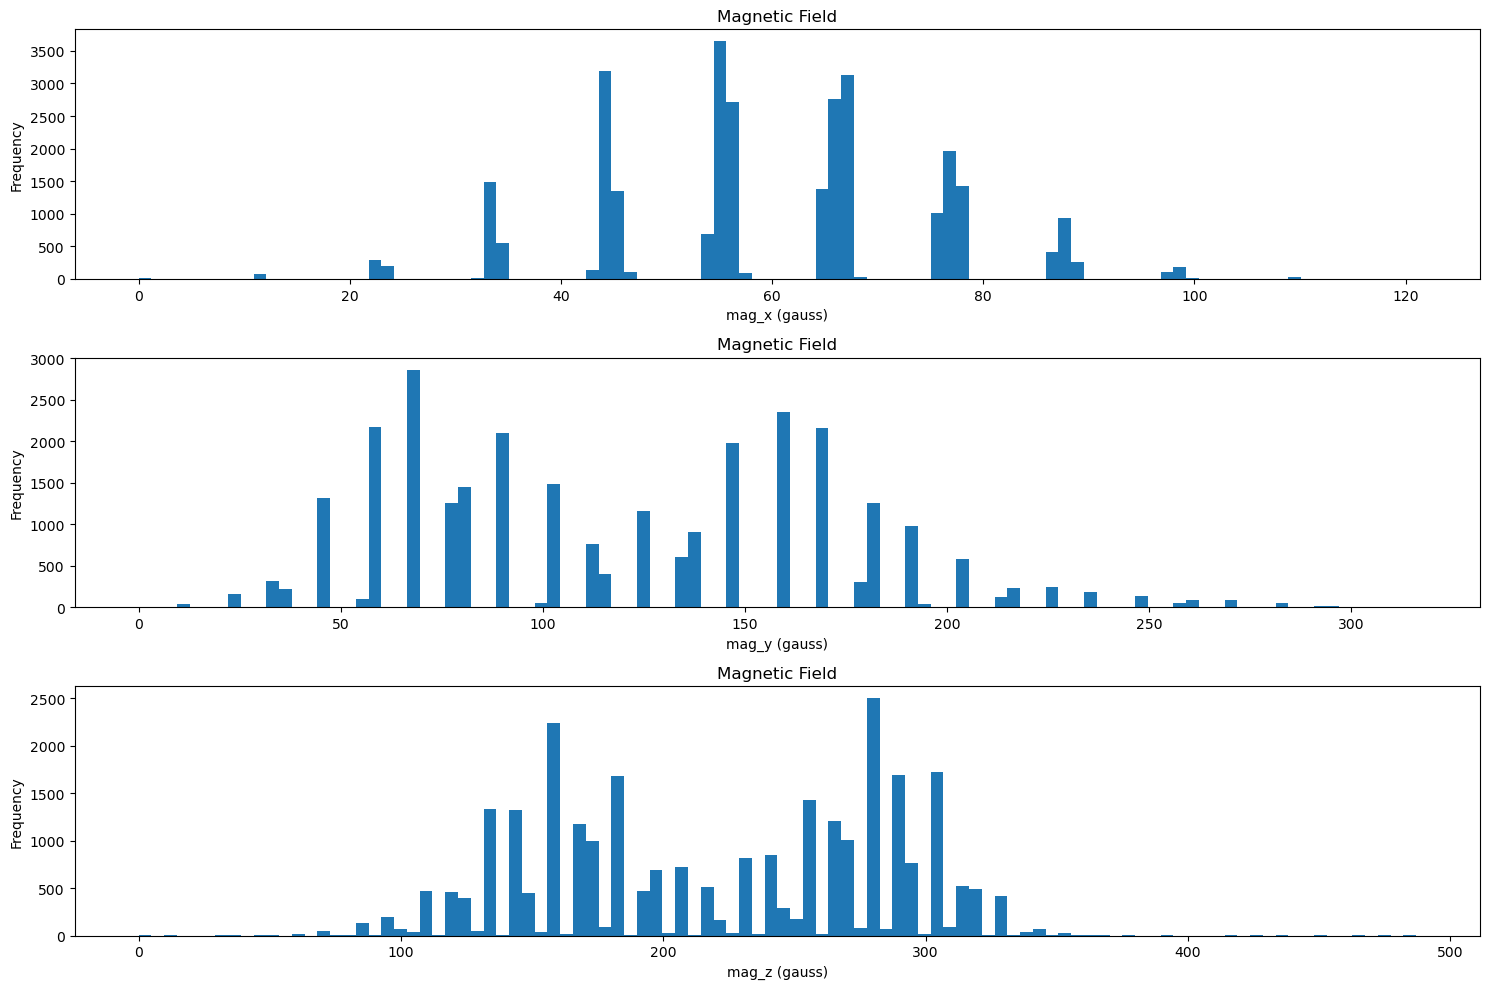

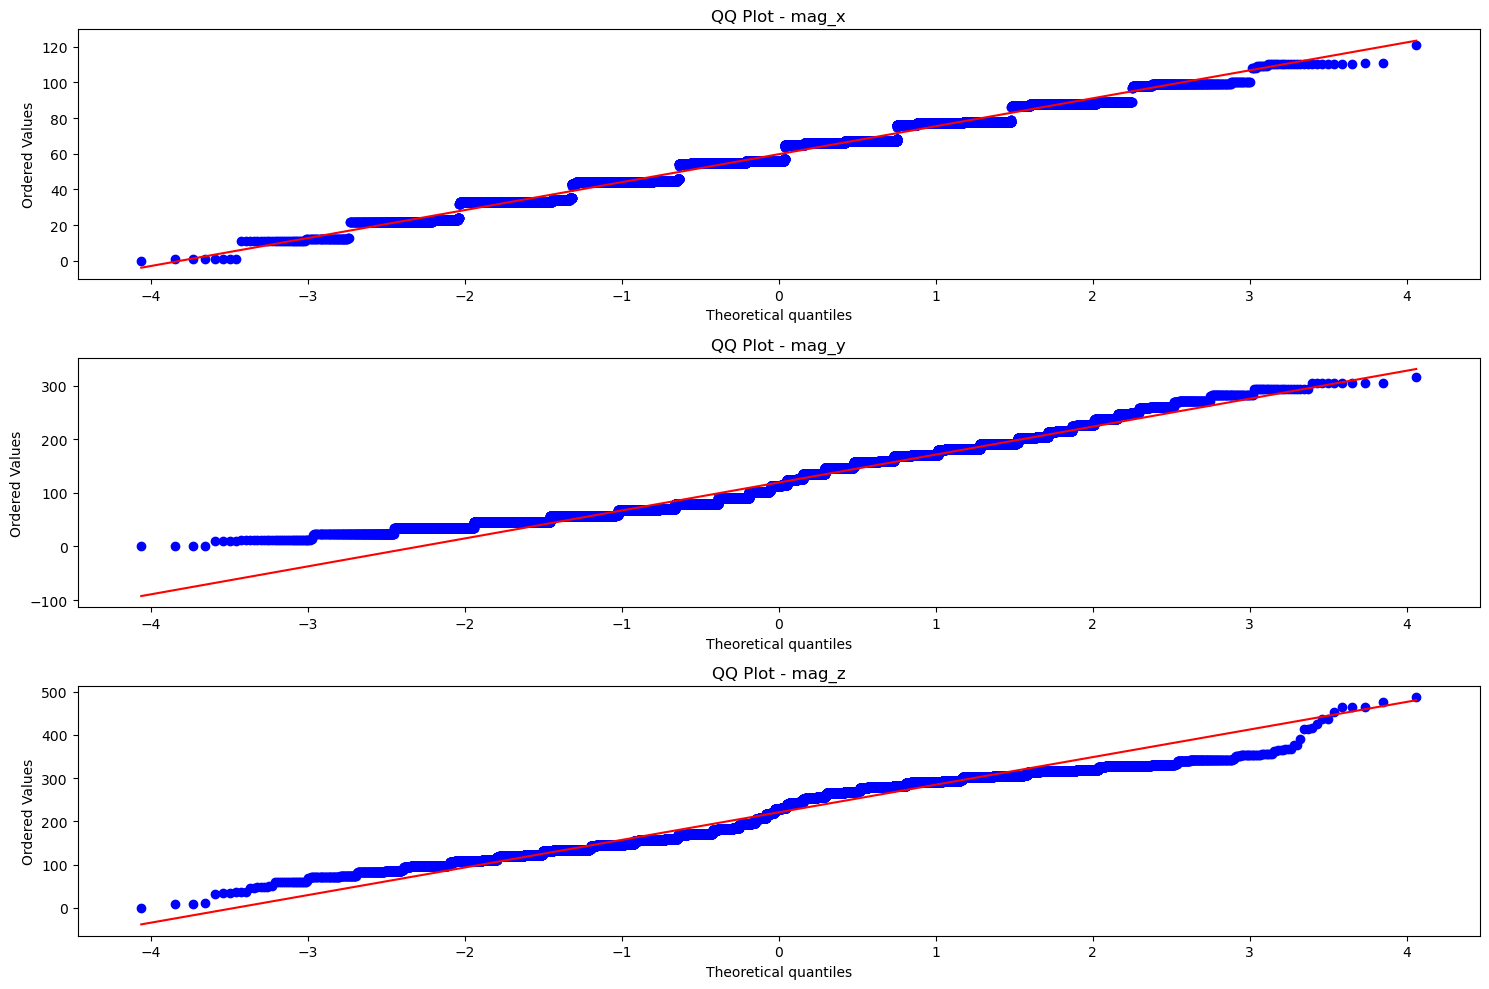

In [173]:
plot_time_graphs(['mag_x', 'mag_y', 'mag_z'], 'Magnetic Field', 'gauss')
plot_histogrames(['mag_x', 'mag_y', 'mag_z'], 'Magnetic Field', 'gauss')
check_distribution_QQ(['mag_x', 'mag_y', 'mag_z'])